# Recombined ligands in ChEMBL: Exact vs. most similar matches

In [1]:
from datetime import datetime
from pathlib import Path

import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator

from utils import read_fragment_library, construct_ligand, standardize_mol

## Calculate similarity by hand

Add function here (same structure as in kffl module) to calculate similarity by hand for example recombined ligand with example ChEMBL ligand.

In [2]:
def calculate_similarity(chembl_id, recombined_ligand, recombined_ligand_construction=1): 
    """
    Calculate similarity between a recombined ligand and a ChEMBL ligand.
    
    Parameters
    ----------
    chembl_id : str
        Molecule ChEMBL ID.
    recombined_ligand : pandas.Series
        Recombined ligand data.
    use_recombined_ligand_inchi : int
        If 1, construct recombined ligand from InChI > ROMol
        If 2, construct recombined ligand from bond and fragment IDs > ROMol.
        If 3, construct recombined ligand from bond and fragment IDs > ROMol > InChI > ROMol.
        
    Returns
    -------
    float
        Similarity.
    """

    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

    chembl_inchis = chembl[chembl.chembl_id == chembl_id].inchi.to_list()
    chembl_mol = [Chem.MolFromInchi(i) for i in chembl_inchis]
    
    if recombined_ligand_construction == 1:
        query_inchi = recombined_ligand.inchi
        query_mol = Chem.MolFromInchi(query_inchi)
    elif recombined_ligand_construction == 2:
        query_mol = construct_ligand(
            recombined_ligand.fragment_ids, 
            recombined_ligand.bond_ids, 
            fragment_library
        )
        query_mol = standardize_mol(query_mol)
    elif recombined_ligand_construction == 3:
        query_mol = construct_ligand(
            recombined_ligand.fragment_ids, 
            recombined_ligand.bond_ids, 
            fragment_library
        )
        query_mol = standardize_mol(query_mol)
        query_inchi = Chem.MolToInchi(query_mol)
        query_mol = Chem.MolFromInchi(query_inchi)
        

    chembl_fingerprints = [rdkit_gen.GetFingerprint(i) for i in chembl_mol]
    query_fingerprint = rdkit_gen.GetFingerprint(query_mol)

    return DataStructs.BulkTanimotoSimilarity(query_fingerprint, chembl_fingerprints)[0]

In [3]:
def compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=1):
    """
    Get similarities between a recombined ligand and 
    (a) the ChEMBL ligand that was returned as exact match and
    (b) the ChEMBL ligand that was returned as most similar ligand.
    
    Parameters
    ----------
    recombined_ligand : pandas.Series
        Recombined ligand data.
    chembl : pandas.DataFrame
        ChEMBL data (ChEMBL ID and standardized InChI)
    use_recombined_ligand_inchi : bool
        If true, construct recombined ligand from InChI > ROMol
        If false, construct recombined ligand from bond and fragment IDs > ROMol.
    """
    
    # Get ChEMBL ID of ChEMBL ligand that was returned as exact match
    chembl_id = chembl[chembl.inchi == recombined_ligand.inchi].chembl_id.iloc[0]
    print(f'Exact ChEMBL match: {chembl_id}')
    similarity_exact_match = calculate_similarity(
        chembl_id, 
        recombined_ligand,
        recombined_ligand_construction
    )
    print(similarity_exact_match)

    # Get ChEMBL ID of ChEMBL ligand that was returned as most similar ChEMBL ligand
    chembl_id = recombined_ligand.chembl_most_similar[0]
    print(f'Most similar ChEMBL match: {chembl_id}')
    similarity_most_similar = calculate_similarity(
        chembl_id, 
        recombined_ligand,
        recombined_ligand_construction
    )
    print(similarity_most_similar)

In [4]:
# Side note (checking if indexing with idxmax and loc as expected - yes!)
a = pd.DataFrame([[10,1,30], [1,2,3]], index=['a', 'b'], columns='x y z'.split())
ix = a.x.idxmax()
a.loc[ix]

x    10
y     1
z    30
Name: a, dtype: int64

## Get ChEMBL dataset (standardized by us)

In [5]:
chembl = pd.read_csv('../data/combinatorial_library/chembl_standardized_inchi.csv')

In [6]:
chembl.shape

(1782229, 2)

In [7]:
chembl.head(2)

,chembl_id,inchi
0,CHEMBL153534,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...
1,CHEMBL440060,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...


## Get exact matches

In [8]:
exact_matches = pd.read_json('../data/combinatorial_library/chembl_exact.json')
print(f'Number of exact matches: {exact_matches.shape[0]}')
exact_matches.head(2)

Number of exact matches: 298


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[GA_10, B1_7], [GA_9, AP_11], [AP_12, SE_13]]","[B1_19, GA_35, AP_6, SE_1]",1,1,0,0,40,1,"[CHEMBL2347516, 1.0]",0,0,InChI=1S/C32H28ClFN4O2/c33-29-18-27(9-11-31(29...
1,"[[SE_8, AP_8], [FP_6, AP_9]]","[AP_99, SE_16, FP_25]",1,1,1,1,22,1,"[CHEMBL265923, 1.0]",0,0,InChI=1S/C16H13N3O2S/c1-21-13-6-4-12(5-7-13)18...


## Get reduced fragment library

In [9]:
fragment_library = read_fragment_library(Path('../data/fragment_library_reduced/'))

## Exact matches have similarity of 1.0?

In theory, the exact matches should have a similarity of 1.0. 

Procedure for calculating (i) exact matches and (ii) similarities.
- (i) Recombined ligands are constructed as `ROMol`, standardized, `ROMol` > `InChI` (InChI as basis for comparison)
- (ii) Recombined ligands are constructed as `ROMol`, standardized and directly used for fingerprint generation.

In [10]:
exact_matches_not_1 = exact_matches[exact_matches.apply(lambda x: x.chembl_most_similar[1] != 1.0, axis=1)]
print(f'Number of exact matches with similarity != 1: {exact_matches_not_1.shape[0]}')
exact_matches_not_1

Number of exact matches with similarity != 1: 100


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
2,"[[FP_6, AP_9], [AP_8, SE_6]]","[AP_99, FP_103, SE_138]",1,1,1,1,20,1,"[CHEMBL1446166, 0.9400000000000001]",0,0,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
5,"[[FP_6, AP_9], [SE_15, AP_8]]","[AP_99, SE_9, FP_25]",1,1,1,1,29,1,"[CHEMBL254546, 0.87]",0,0,InChI=1S/C21H23N5O2S/c1-25-8-10-26(11-9-25)16-...
6,"[[FP_6, AP_9], [SE_3, AP_8]]","[AP_99, FP_103, SE_74]",1,1,1,1,17,1,"[CHEMBL4070122, 0.79]",0,0,InChI=1S/C13H12N2OS/c1-2-8-14-12(16)11-9-17-13...
8,"[[FP_10, AP_8], [SE_10, AP_9]]","[AP_95, SE_22, FP_14]",1,1,1,1,28,1,"[CHEMBL2203552, 0.71]",1,1,InChI=1S/C21H17N5O2/c1-28-18-11-24-20(13-8-12-...
10,"[[SE_12, AP_8], [FP_6, AP_9]]","[AP_99, FP_103, SE_15]",1,1,1,1,26,1,"[CHEMBL265923, 0.8200000000000001]",0,0,InChI=1S/C19H18N2O4S/c1-23-15-9-13(10-16(24-2)...
...,...,...,...,...,...,...,...,...,...,...,...,...
279,"[[GA_4, AP_6]]","[GA_47, AP_139]",1,1,1,1,10,1,"[CHEMBL1288882, 0.6900000000000001]",0,0,"InChI=1S/C3H2F3N3S/c4-3(5,6)1-8-9-2(7)10-1/h(H..."
282,"[[SE_11, AP_9]]","[SE_130, AP_32]",1,1,1,1,20,1,"[CHEMBL1724387, 0.8200000000000001]",0,1,InChI=1S/C16H13N3O/c20-16(13-9-5-2-6-10-13)17-...
288,"[[AP_16, FP_8]]","[AP_112, FP_19]",1,1,1,1,24,1,"[CHEMBL257317, 0.72]",0,0,InChI=1S/C20H16N2O2/c1-24-15-6-4-5-13(11-15)14...
292,"[[AP_9, SE_9]]","[SE_35, AP_32]",1,1,1,1,18,1,"[CHEMBL1427072, 0.99]",0,1,InChI=1S/C14H11N3O/c18-13(10-6-2-1-3-7-10)17-1...


## Example recombined ligands

### Example 1

In [11]:
recombined_ligand = exact_matches.loc[2, :]
recombined_ligand

bond_ids                                      [[FP_6, AP_9], [AP_8, SE_6]]
fragment_ids                                       [AP_99, FP_103, SE_138]
hba                                                                      1
hbd                                                                      1
mwt                                                                      1
logp                                                                     1
n_atoms                                                                 20
chembl_exact                                                             1
chembl_most_similar                    [CHEMBL1446166, 0.9400000000000001]
original_exact                                                           0
original_substructure                                                    0
inchi                    InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...
Name: 2, dtype: object

In [12]:
# Get exact ChEMBL match
chembl[chembl.inchi == recombined_ligand.inchi]

,chembl_id,inchi
840804,CHEMBL1458369,InChI=1S/C16H12N2OS/c19-15(17-13-9-5-2-6-10-13...


Compare in ChEMBL:

- ChEMBL - most similar: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL1446166/
- ChEMBL - exact match: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL1458369/

#### Construct ligand from metadata/InChI

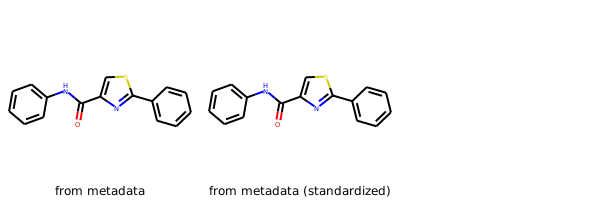

In [13]:
# Construct ligand from metadata
mol_from_metadata = construct_ligand(
    recombined_ligand.fragment_ids, 
    recombined_ligand.bond_ids,
    fragment_library
)
Chem.Draw.MolsToGridImage(
    [mol_from_metadata, standardize_mol(mol_from_metadata)], 
    legends=['from metadata', 'from metadata (standardized)']
)

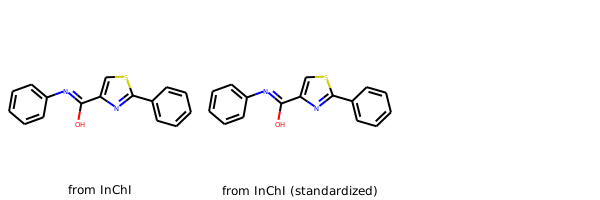

In [14]:
# Construct ligand from InChI
mol_from_inchi = Chem.MolFromInchi(recombined_ligand.inchi)
Chem.Draw.MolsToGridImage(
    [mol_from_inchi, standardize_mol(mol_from_inchi)], 
    legends=['from InChI', 'from InChI (standardized)']
)

#### Calculate similarity

In [15]:
print('Recombined ligand: Use InchI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=1)
print()
print('Recombined ligand: Use metadata > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=2)
print()
print('Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=3)

Recombined ligand: Use InchI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1458369
1.0
Most similar ChEMBL match: CHEMBL1446166
0.48484848484848486

Recombined ligand: Use metadata > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1458369
0.5052910052910053
Most similar ChEMBL match: CHEMBL1446166
0.9368770764119602

Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1458369
1.0
Most similar ChEMBL match: CHEMBL1446166
0.48484848484848486


similarity:  0.5052910052910053


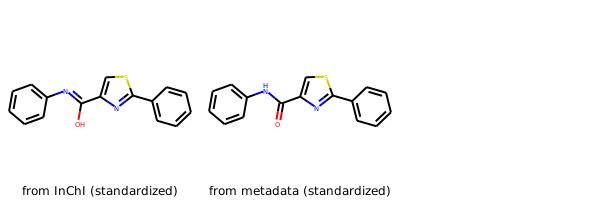

In [16]:
# Check again similarity
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
print('similarity: ',
    DataStructs.TanimotoSimilarity(
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_inchi)), 
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_metadata))
    )
)
Chem.Draw.MolsToGridImage(
    [standardize_mol(mol_from_inchi), standardize_mol(mol_from_metadata)], 
    legends=['from InChI (standardized)', 'from metadata (standardized)']
)

### Example 2

In [17]:
recombined_ligand = exact_matches.loc[5, :]
recombined_ligand

bond_ids                                     [[FP_6, AP_9], [SE_15, AP_8]]
fragment_ids                                          [AP_99, SE_9, FP_25]
hba                                                                      1
hbd                                                                      1
mwt                                                                      1
logp                                                                     1
n_atoms                                                                 29
chembl_exact                                                             1
chembl_most_similar                                   [CHEMBL254546, 0.87]
original_exact                                                           0
original_substructure                                                    0
inchi                    InChI=1S/C21H23N5O2S/c1-25-8-10-26(11-9-25)16-...
Name: 5, dtype: object

In [18]:
# Get exact ChEMBL match
chembl[chembl.inchi == recombined_ligand.inchi]

,chembl_id,inchi
229870,CHEMBL257127,InChI=1S/C21H23N5O2S/c1-25-8-10-26(11-9-25)16-...


Compare in ChEMBL:

- ChEMBL - most similar: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL254546/
- ChEMBL - exact match: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL257127/

#### Construct ligand from metadata/InChI

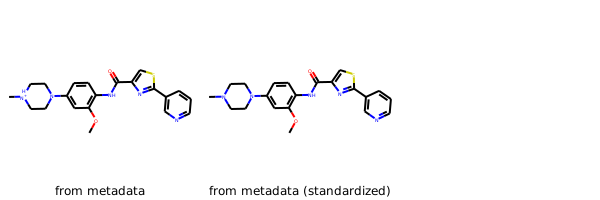

In [19]:
# Construct ligand from metadata
mol_from_metadata = construct_ligand(
    recombined_ligand.fragment_ids, 
    recombined_ligand.bond_ids,
    fragment_library
)
Chem.Draw.MolsToGridImage(
    [mol_from_metadata, standardize_mol(mol_from_metadata)], 
    legends=['from metadata', 'from metadata (standardized)']
)

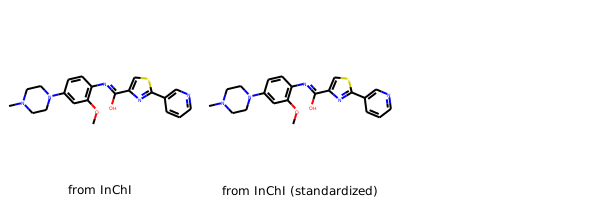

In [20]:
# Construct ligand from InChI
mol_from_inchi = Chem.MolFromInchi(recombined_ligand.inchi)
Chem.Draw.MolsToGridImage(
    [mol_from_inchi, standardize_mol(mol_from_inchi)], 
    legends=['from InChI', 'from InChI (standardized)']
)

#### Calculate similarity

In [21]:
print('Recombined ligand: Use InchI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=1)
print()
print('Recombined ligand: Use metadata > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=2)
print()
print('Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=3)

Recombined ligand: Use InchI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL257127
1.0
Most similar ChEMBL match: CHEMBL254546
0.566990291262136

Recombined ligand: Use metadata > ROMol > fingerprint
Exact ChEMBL match: CHEMBL257127
0.6525911708253359
Most similar ChEMBL match: CHEMBL254546
0.8729411764705882

Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL257127
1.0
Most similar ChEMBL match: CHEMBL254546
0.566990291262136


similarity:  0.6525911708253359


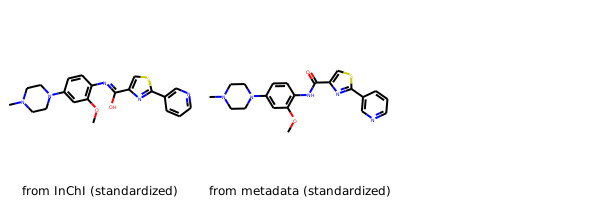

In [22]:
# Check again similarity
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
print('similarity: ',
    DataStructs.TanimotoSimilarity(
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_inchi)), 
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_metadata))
    )
)
Chem.Draw.MolsToGridImage(
    [standardize_mol(mol_from_inchi), standardize_mol(mol_from_metadata)], 
    legends=['from InChI (standardized)', 'from metadata (standardized)']
)

### Example 3

In [23]:
recombined_ligand = exact_matches.loc[6, :]
recombined_ligand

bond_ids                                      [[FP_6, AP_9], [SE_3, AP_8]]
fragment_ids                                        [AP_99, FP_103, SE_74]
hba                                                                      1
hbd                                                                      1
mwt                                                                      1
logp                                                                     1
n_atoms                                                                 17
chembl_exact                                                             1
chembl_most_similar                                  [CHEMBL4070122, 0.79]
original_exact                                                           0
original_substructure                                                    0
inchi                    InChI=1S/C13H12N2OS/c1-2-8-14-12(16)11-9-17-13...
Name: 6, dtype: object

In [24]:
# Get exact ChEMBL match
chembl[chembl.inchi == recombined_ligand.inchi]

,chembl_id,inchi
700447,CHEMBL1349528,InChI=1S/C13H12N2OS/c1-2-8-14-12(16)11-9-17-13...


Compare in ChEMBL:

- ChEMBL - most similar: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL4070122/
- ChEMBL - exact match: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL1349528/

#### Construct ligand from metadata/InChI

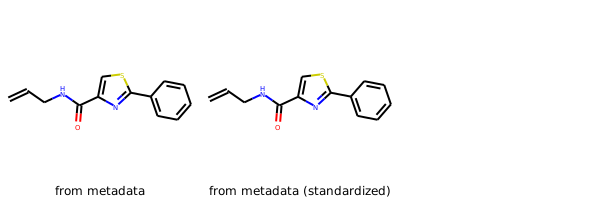

In [25]:
# Construct ligand from metadata
mol_from_metadata = construct_ligand(
    recombined_ligand.fragment_ids, 
    recombined_ligand.bond_ids,
    fragment_library
)
Chem.Draw.MolsToGridImage(
    [mol_from_metadata, standardize_mol(mol_from_metadata)], 
    legends=['from metadata', 'from metadata (standardized)']
)

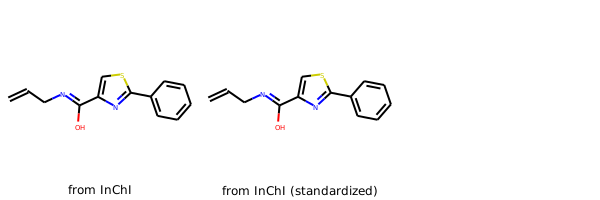

In [26]:
# Construct ligand from InChI
mol_from_inchi = Chem.MolFromInchi(recombined_ligand.inchi)
Chem.Draw.MolsToGridImage(
    [mol_from_inchi, standardize_mol(mol_from_inchi)], 
    legends=['from InChI', 'from InChI (standardized)']
)

#### Calculate similarity

In [27]:
print('Recombined ligand: Use InchI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=1)
print()
print('Recombined ligand: Use metadata > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=2)
print()
print('Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=3)

Recombined ligand: Use InchI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1349528
1.0
Most similar ChEMBL match: CHEMBL4070122
0.4630541871921182

Recombined ligand: Use metadata > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1349528
0.5252808988764045
Most similar ChEMBL match: CHEMBL4070122
0.7944785276073619

Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL1349528
1.0
Most similar ChEMBL match: CHEMBL4070122
0.4630541871921182


similarity:  0.5252808988764045


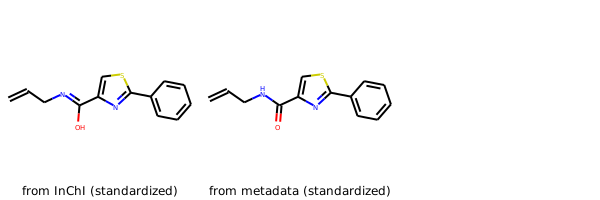

In [28]:
# Check again similarity
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
print('similarity: ',
    DataStructs.TanimotoSimilarity(
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_inchi)), 
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_metadata))
    )
)
Chem.Draw.MolsToGridImage(
    [standardize_mol(mol_from_inchi), standardize_mol(mol_from_metadata)], 
    legends=['from InChI (standardized)', 'from metadata (standardized)']
)

### Example 4

In [29]:
recombined_ligand = exact_matches.loc[8, :]
recombined_ligand

bond_ids                                    [[FP_10, AP_8], [SE_10, AP_9]]
fragment_ids                                         [AP_95, SE_22, FP_14]
hba                                                                      1
hbd                                                                      1
mwt                                                                      1
logp                                                                     1
n_atoms                                                                 28
chembl_exact                                                             1
chembl_most_similar                                  [CHEMBL2203552, 0.71]
original_exact                                                           1
original_substructure                                                    1
inchi                    InChI=1S/C21H17N5O2/c1-28-18-11-24-20(13-8-12-...
Name: 8, dtype: object

In [30]:
# Get exact ChEMBL match
chembl[chembl.inchi == recombined_ligand.inchi]

,chembl_id,inchi
1190263,CHEMBL2203552,InChI=1S/C21H17N5O2/c1-28-18-11-24-20(13-8-12-...


Compare in ChEMBL (same ChEMBL ID but similarity < 1!!!):

- ChEMBL - most similar: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL2203552/
- ChEMBL - exact match: https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL2203552/

#### Construct ligand from metadata/InChI

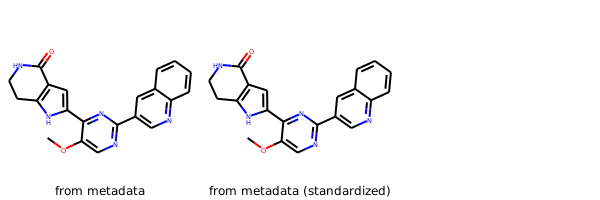

In [31]:
# Construct ligand from metadata
mol_from_metadata = construct_ligand(
    recombined_ligand.fragment_ids, 
    recombined_ligand.bond_ids,
    fragment_library
)
Chem.Draw.MolsToGridImage(
    [mol_from_metadata, standardize_mol(mol_from_metadata)], 
    legends=['from metadata', 'from metadata (standardized)']
)

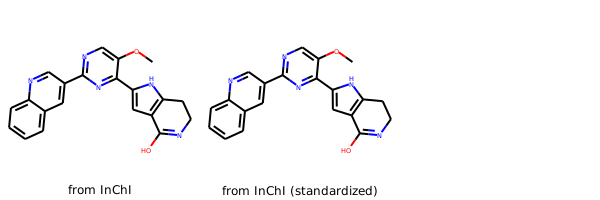

In [32]:
# Construct ligand from InChI
mol_from_inchi = Chem.MolFromInchi(recombined_ligand.inchi)
Chem.Draw.MolsToGridImage(
    [mol_from_inchi, standardize_mol(mol_from_inchi)], 
    legends=['from InChI', 'from InChI (standardized)']
)

#### Calculate similarity

In [33]:
print('Recombined ligand: Use InchI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=1)
print()
print('Recombined ligand: Use metadata > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=2)
print()
print('Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint')
compare_similarity_exact_vs_most_similar(recombined_ligand, chembl, recombined_ligand_construction=3)

Recombined ligand: Use InchI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL2203552
1.0
Most similar ChEMBL match: CHEMBL2203552
1.0

Recombined ligand: Use metadata > ROMol > fingerprint
Exact ChEMBL match: CHEMBL2203552
0.7076648841354723
Most similar ChEMBL match: CHEMBL2203552
0.7076648841354723

Recombined ligand: Use metadata > ROMol > InChI > ROMol > fingerprint
Exact ChEMBL match: CHEMBL2203552
1.0
Most similar ChEMBL match: CHEMBL2203552
1.0


similarity:  0.7076648841354723


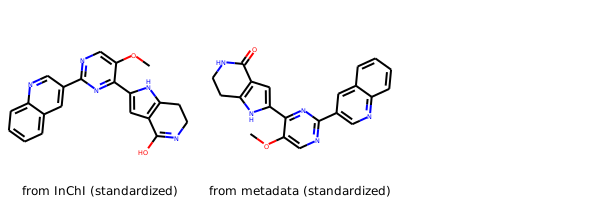

In [34]:
# Check again similarity
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
print('similarity: ',
    DataStructs.TanimotoSimilarity(
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_inchi)), 
        rdkit_gen.GetFingerprint(standardize_mol(mol_from_metadata))
    )
)
Chem.Draw.MolsToGridImage(
    [standardize_mol(mol_from_inchi), standardize_mol(mol_from_metadata)], 
    legends=['from InChI (standardized)', 'from metadata (standardized)']
)

## Appendix

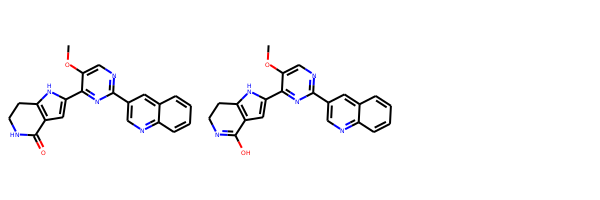

In [35]:
smi1='COc1cnc(-c2cnc3ccccc3c2)nc1-c1cc2c([nH]1)CCNC2=O'
smi2='COc1cnc(-c2cnc3ccccc3c2)nc1-c1cc2c([nH]1)CCN=C2O'
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi1), Chem.MolFromSmiles(smi2)])

In [36]:
inchi1=Chem.MolToInchi(Chem.MolFromSmiles(smi1))
inchi2=Chem.MolToInchi(Chem.MolFromSmiles(smi2))
print(smi1==smi2)
print(inchi1==inchi2)

False
True
